### Datashader Network

In [1]:
import pandas as pd

import networkx as nx

from sklearn.preprocessing import LabelEncoder

import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.bundling import hammer_bundle
from datashader.layout import forceatlas2_layout 

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
cvsopts = dict(plot_height=800, plot_width=800)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator = None if cat is None else ds.count_cat(cat)
    agg = canvas.points(nodes, 'x', 'y', aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x', 'y', agg=ds.count()), name=name)

def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = (nodes.x.min(), nodes.x.max())
        yr = (nodes.y.min(), nodes.y.max())
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

def export_graph_image(nodes, edges, filename='', cat=None):
    img = graphplot(nodes, edges, cat=cat)  
    export_image(img=img, filename=filename, fmt=".png", background='white')

In [3]:
df = pd.read_csv("../output/Survivor/vote_history.csv")
df = df[df.version == "US"]
df['castaway_uid']  = df['season'].astype(str) + df['castaway']
df['vote_uid']  = df['season'].astype(str) + df['vote']
df = df.dropna(subset=['vote'])

In [4]:
G = nx.DiGraph()
for _, row in df.iterrows():
    voter = row['castaway_uid']
    voted_against = row['vote_uid']
    if G.has_edge(voter, voted_against):
        G[voter][voted_against]['weight'] += 1
    else:
        G.add_edge(voter, voted_against, weight=1)

In [5]:
pos = nx.kamada_kawai_layout(G)

Generate dataset dataframe

In [6]:
nodes = pd.DataFrame({'x': [coords[0] for coords in pos.values()], 'y': [coords[1] for coords in pos.values()]})

le = LabelEncoder()
le.fit(G.nodes())

edges = list(zip([edge[0] for edge in G.edges()], [edge[1] for edge in G.edges()])) 
edges_df = pd.DataFrame(edges, columns=['source', 'target'])

edges_df['source'] = le.transform(edges_df['source'])
edges_df['target'] = le.transform(edges_df['target'])

Graph datashader networks

Force-directed Edge Bundling of Survivor Voting Network,Edge Bundling of Survivor Voting Network

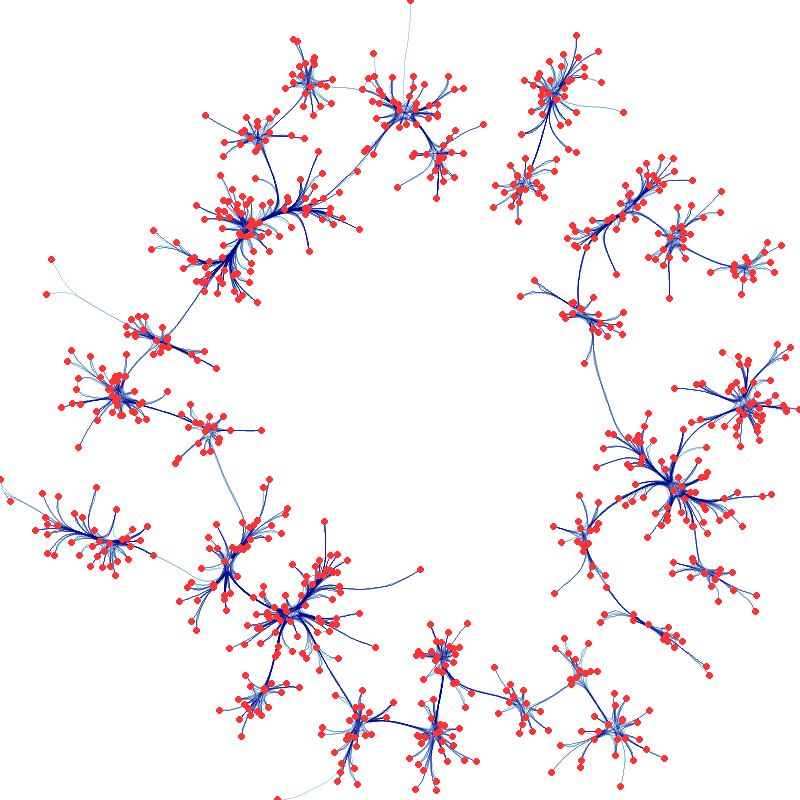
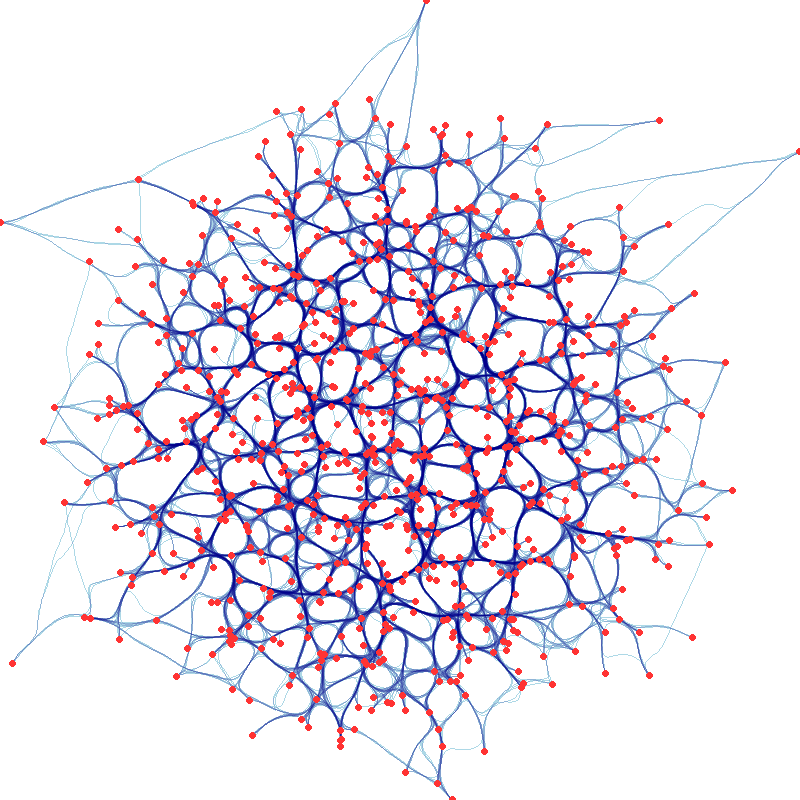

In [7]:
hb_plot = graphplot(nodes, hammer_bundle(nodes, edges_df, initial_bandwidth=0.02), "Edge Bundling of Survivor Voting Network")

fd = forceatlas2_layout(nodes, edges_df)
fd_c = graphplot(nodes=fd, edges=hammer_bundle(fd, edges_df, initial_bandwidth=0.08), name="Force-directed Edge Bundling of Survivor Voting Network")

tf.Images(fd_c, hb_plot)

In [10]:
export_graph_image(nodes, hammer_bundle(nodes, edges_df, initial_bandwidth=0.02), filename='../output/Survivor/survivor_chess_edge_bundles')

In [11]:
export_graph_image(fd, hammer_bundle(fd, edges_df, initial_bandwidth=0.08), filename='../output/Survivor/survivor_fd_edge_bundling')